In [3]:
# This is required to run multiple processes on Unity for some reason.
from multiprocessing import set_start_method
try:
    set_start_method('spawn')
except:
    pass

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax
from pathlib import Path
import importlib

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)

import config, data, models, train, evaluate

In [2]:
importlib.reload(config)
from config import read_config

cfg_path = Path("../runs/example_config.yml")
cfg, cfg_str = read_config(cfg_path)
cfg['quiet'] = False

In [20]:
importlib.reload(config)
from config import format_config

cfg = {
    # Data
    "data_dir": "../data/wqp",
    "basin_file": "metadata/site_lists/sites_test.txt",  # relative to data_dir
    "features": {"daily": ["grfr_q"],
                 "irregular": ["Blue", "Green", "Red", "Nir", "Swir1", "Swir2"],
                 "static": None, # All are used when None
                 "target": "turbidity"},
    "time_slice": ["1979-01-01", "2018-12-31"], 
    "split_time": "2010-01-01",
    "sequence_length": 30,
    "log_norm_cols": ["turbidity","grfr_q"],
    "clip_target_to_zero": True,
    
    # DataLoader
    "shuffle": True,
    "batch_size": 8,
    "data_subset": "train",
    "num_workers": 0,
    "pin_memory": True, 
    
    # Model
    "model": "taplstm",
    "model_args": {"hidden_size": 16,
                   "dropout": 0.4,
                   "seed": 0}, 
    
    # Trainer
    "num_epochs": 10,
    "initial_lr": 0.01,
    "decay_rate": 0.01,
    "step_kwargs":{"loss": "mse",
                   "max_grad_norm": 2}, 
    
    # Outputs
    "quiet": False,  # Use to declutter the slurm output (removes tqdm)
    "log": False
}
cfg = format_config(cfg)

In [21]:
importlib.reload(data)
from data import TAPDataset

dataset = TAPDataset(cfg)

Dropping static attributes with 0 variance: ['glc_pc_s03', 'glc_pc_s05', 'glc_pc_s07', 'glc_pc_s08', 'glc_pc_s17', 'glc_pc_s19', 'pnv_pc_s03', 'wet_pc_s05', 'wet_pc_s06', 'wet_pc_s07']


Loading Basins:   0%|          | 0/10 [00:00<?, ?it/s]

Dataloader using 0 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


Epoch:001:   0%|          | 0/1337 [00:00<?, ?it/s]

vanishing gradients detected:
	.tealstm_i.cell.weight_hh: 8
	.tealstm_i.cell.weight_decomp: 9
	.tealstm_i.cell.input_linear.bias: 5


Epoch:002:   0%|          | 0/1337 [00:00<?, ?it/s]

vanishing gradients detected:
	.tealstm_i.cell.input_linear.bias: 14
	.tealstm_i.cell.weight_hh: 2
	.tealstm_i.cell.weight_decomp: 2


Epoch:003:   0%|          | 0/1337 [00:00<?, ?it/s]

vanishing gradients detected:
	.tealstm_i.cell.input_linear.bias: 9
	.ealstm_d.cell.input_linear.bias: 5
	.tealstm_i.cell.weight_hh: 3
	.tealstm_i.cell.weight_decomp: 3


Epoch:004:   0%|          | 0/1337 [00:00<?, ?it/s]

vanishing gradients detected:
	.ealstm_d.cell.input_linear.bias: 4
	.tealstm_i.cell.input_linear.bias: 47
	.tealstm_i.cell.weight_decomp: 7
	.tealstm_i.cell.weight_hh: 4


Epoch:005:   0%|          | 0/1337 [00:00<?, ?it/s]

vanishing gradients detected:
	.tealstm_i.cell.input_linear.bias: 23
	.ealstm_d.cell.input_linear.bias: 1


Epoch:006:   0%|          | 0/1337 [00:00<?, ?it/s]

vanishing gradients detected:
	.tealstm_i.cell.weight_hh: 5
	.tealstm_i.cell.input_linear.bias: 2
	.tealstm_i.cell.weight_decomp: 6
	.ealstm_d.cell.input_linear.bias: 2
	.tealstm_i.cell.weight_ih: 1
	.tealstm_i.cell.bias: 1
	.tealstm_i.cell.input_linear.weight: 1
	.tealstm_i.cell.bias_decomp: 1


Epoch:007:   0%|          | 0/1337 [00:00<?, ?it/s]

vanishing gradients detected:
	.ealstm_d.cell.input_linear.bias: 1
	.tealstm_i.cell.weight_hh: 1
	.tealstm_i.cell.weight_decomp: 3


Epoch:008:   0%|          | 0/1337 [00:00<?, ?it/s]

Training finished or interrupted. Model state saved.


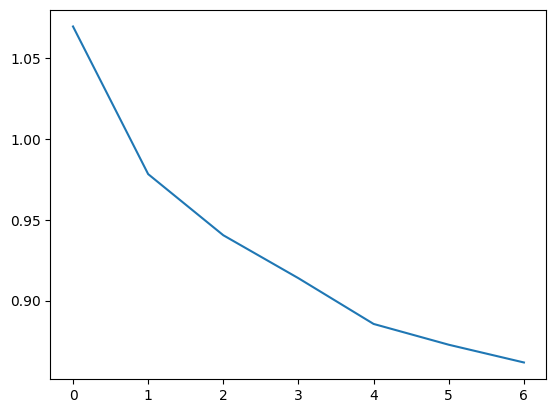

In [22]:
importlib.reload(data)
from data import TAPDataLoader

importlib.reload(models)
from models import TAPLSTM, EALSTM, LSTM

importlib.reload(train)
from train import Trainer

# Model config is a bit more dynamic
model_name = cfg['model'].lower()
if model_name == 'taplstm':
    model_fn = TAPLSTM
    cfg['model_args']['daily_in_size'] = len(dataset.daily_features)
    cfg['model_args']['irregular_in_size'] = len(dataset.irregular_features)
    cfg['model_args']['static_in_size'] = len(dataset.static_features)
elif model_name == 'ealstm':
    model_fn = EALSTM
    cfg['model_args']['dynamic_in_size'] = len(dataset.daily_features)
    cfg['model_args']['static_in_size'] = len(dataset.static_features)
elif model_name == 'tealstm':
    model_fn = TEALSTM
    cfg['model_args']['dynamic_in_size'] = len(dataset.irregular_features)
    cfg['model_args']['static_in_size'] = len(dataset.static_features)
else:
    raise ValueError("Please provide a valid model name (taplstm, ealstm, tealstm)")

dataloader = TAPDataLoader(cfg, dataset)
trainer = Trainer(cfg, dataloader, model_fn)
trainer.start_training()


In [ ]:
import optax

more_epochs = 150

trainer.load_state('epoch100')
loader_args['data_subset'] = 'train'
trainer.dataloader = TAPDataLoader(dataset, **loader_args)
trainer.lr_schedule = optax.exponential_decay(0.01, trainer.epoch+more_epochs, 0.001, transition_begin=trainer.epoch)
trainer.num_epochs += more_epochs
trainer.freeze_components('tealstm_i',True)
trainer.start_training() 

In [ ]:
lr_schedule = optax.exponential_decay(0.01, trainer.epoch+num_epochs, 0.001, transition_begin=trainer.epoch)
x = np.linspace(0,num_epochs*2)
y = lr_schedule(x)
plt.plot(x,y)

In [ ]:
importlib.reload(evaluate)
from evaluate import predict, get_all_metrics

basin = np.random.choice(basin_list).tolist()

loader_args['data_subset'] = 'test'
loader_args['basin_subset'] =  basin
loader_args['num_workers'] = 0 # Faster for small runs
dataloader = TAPDataLoader(dataset, **loader_args)

results = predict(trainer.model, dataloader, denormalize=True)
results['pred'] = results['pred'] * (results['pred']>0) #Clip predictions to 0
metrics = get_all_metrics(results['obs'],results['pred'])
metrics

In [ ]:
results

In [ ]:
# Plot the true values and predictions
fig, ax = plt.subplots(figsize=(12, 6))
results['pred'].plot(ax=ax)
results['obs'].plot(ax=ax,linestyle='None',marker='.')

metrics = get_all_metrics(results['obs'],results['pred'])

plt.title(f"Basin: {basin}, KGE: {metrics['kge']:0.4f}")
plt.legend()
plt.ylim([0,500])
plt.show()

In [ ]:
results.plot.scatter('obs','pred')
plt.gca().axis('square')
plt.xlim([0,20])
plt.ylim([0,20])
plt.show()

In [ ]:
from train import make_step
from tqdm.notebook import trange

# See if we can recreate the error... 
data = trainer.load_state("exceptions/epoch130_exception0")
for i in trange(1000):
    make_step(trainer.model, data['batch'], trainer.opt_state, trainer.optim,
              trainer.filter_spec, loss_name="mse", max_grad_norm=None, l2_weight=None)